/tmp/ipykernel_7039/1143829525.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if data['Signal'][i] == 1:  # Signal d'achat
/tmp/ipykernel_7039/1143829525.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif data['Signal'][i] == -1:  # Signal de vente
/tmp/ipykernel_7039/1143829525.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  positions.append(data['Chandelier_Long'][i])
/tmp/ipykernel_7039/1143829525.py:51: FutureW

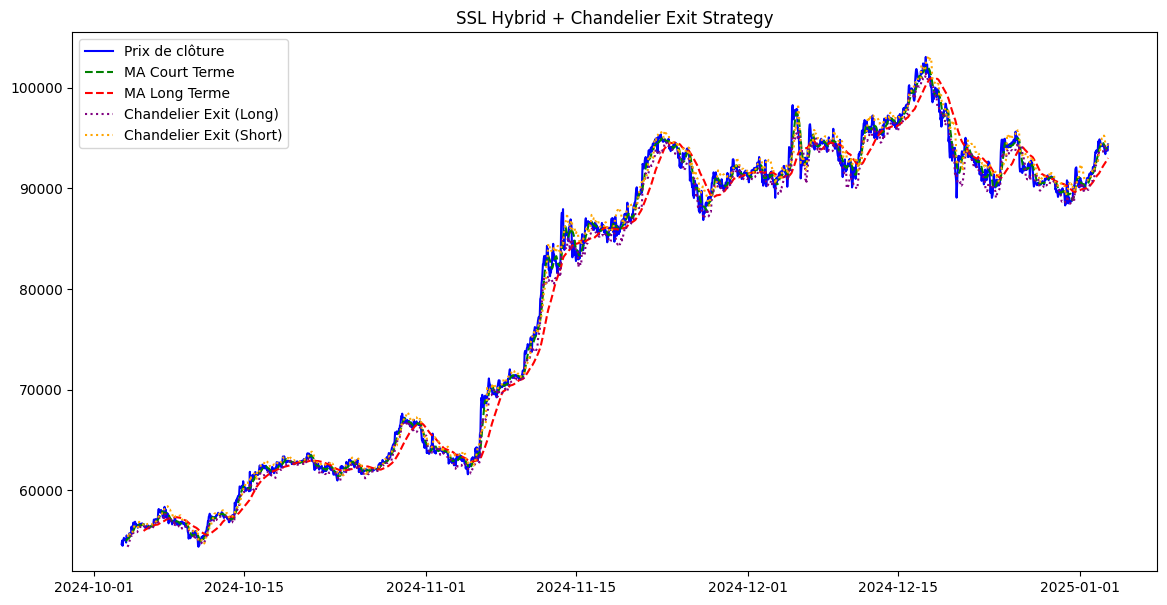

In [15]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Fonction pour calculer les moyennes mobiles
def calculate_ma(data, period):
    return data.rolling(window=period).mean()

# Fonction pour calculer l'ATR
def calculate_atr(data, period):
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift(1))
    low_close = np.abs(data['Low'] - data['Close'].shift(1))
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    return true_range.rolling(window=period).mean()

# Charger les données (format CSV)
data = pd.read_csv('BTC-EUR_ticker.csv')  # Remplacez par le chemin de vos données
try:
    data['Date'] = pd.to_datetime(data['Date'])
except:
    data['Date'] = pd.to_datetime(data['Datetime'])
data.set_index('Date', inplace=True)

# Paramètres de la stratégie
short_ma_period = 10
long_ma_period = 50
atr_period = 14
atr_multiplier = 3

# Calcul des indicateurs
data['Short_MA'] = calculate_ma(data['Close'], short_ma_period)
data['Long_MA'] = calculate_ma(data['Close'], long_ma_period)
data['ATR'] = calculate_atr(data, atr_period)

# Génération des signaux SSL Hybrid
data['Signal'] = 0
data.loc[data['Short_MA'] > data['Long_MA'], 'Signal'] = 1  # Achat
data.loc[data['Short_MA'] < data['Long_MA'], 'Signal'] = -1  # Vente

# Calcul du Chandelier Exit
data['Chandelier_Long'] = data['High'].rolling(window=atr_period).max() - (data['ATR'] * atr_multiplier)
data['Chandelier_Short'] = data['Low'].rolling(window=atr_period).min() + (data['ATR'] * atr_multiplier)

# Stratégie
positions = []
for i in range(len(data)):
    if data['Signal'][i] == 1:  # Signal d'achat
        positions.append(data['Chandelier_Long'][i])
    elif data['Signal'][i] == -1:  # Signal de vente
        positions.append(data['Chandelier_Short'][i])
    else:
        positions.append(None)

data['Position'] = positions

# Visualisation
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Prix de clôture', color='blue')
plt.plot(data['Short_MA'], label='MA Court Terme', color='green', linestyle='--')
plt.plot(data['Long_MA'], label='MA Long Terme', color='red', linestyle='--')
plt.plot(data['Chandelier_Long'], label='Chandelier Exit (Long)', color='purple', linestyle=':')
plt.plot(data['Chandelier_Short'], label='Chandelier Exit (Short)', color='orange', linestyle=':')
plt.title('SSL Hybrid + Chandelier Exit Strategy')
plt.legend()
plt.show()